In [7]:
# Dataset testing
import h5py

# curr_dir = os.path.dirname(os.path.abspath(__file__))
#parent_dir = os.path.dirname(curr_dir)
#sys.path.append(parent_dir)

file_path = "../data/external/main_data.hdf5"

with h5py.File(file_path, "r") as f:
    episode_87 = f["episode_87"]
    # Print all the keys inside episode_87 (actions, infos, etc.)
    print("Keys in episode_87:", list(episode_87.keys()))

    actions = episode_87["actions"][:]
    observations = episode_87["observations_data"][:]
    rewards_to_go = episode_87["rewards_to_go"][:]
    time_to_go = episode_87["time_to_go"][:]


print(f"Actions shape: {actions.shape}")
print(f"Observations shape: {observations.shape}")
print(f"Rewards to go shape: {rewards_to_go.shape}")
print(f"Time to go shape: {time_to_go.shape}")


Keys in episode_87: ['actions', 'infos', 'observations', 'observations_data', 'removed_last_obervation', 'rewards', 'rewards_to_go', 'terminations', 'time_to_go', 'truncations']
Actions shape: (1000, 8)
Observations shape: (1000, 105)
Rewards to go shape: (1000,)
Time to go shape: (1000,)


In [14]:
import torch.nn as nn


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)  # Fully connected layer 1
        self.fc3 = nn.Linear(hidden_size//2, output_size)  # Fully connected layer 2
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x 


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape rewards_to_go and time_to_go to be 2D with shape (1000, 1)
rewards_to_go = rewards_to_go.reshape(-1, 1)
time_to_go = time_to_go.reshape(-1, 1)

X = np.concatenate((observations, rewards_to_go, time_to_go), axis=-1)
y = actions  

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)
print(f"Train-test split created: {len(X_train)} train samples, {len(X_test)} test samples, {len(X_val)} validation samples.")

X shape: (1000, 107)
y shape: (1000, 8)
Train-test split created: 810 train samples, 100 test samples, 90 validation samples.


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert the numpy data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim

# Model initialization
input_size = 105 + 2 # s_t + d_r and d_t
hidden_size = 256
output_size = 8  
model = NeuralNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Loss function and optimizer
loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_losses = []
train_losses = []

smallest_val_loss = float('inf')
patience = 3

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    # TRAINING
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # EVALUATION
    model.eval()  
    val_loss = 0.0
    with torch.no_grad():  
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    # Early stopping
    if val_loss < smallest_val_loss:
        patience = 3
        smallest_val_loss = val_loss
        # torch.save(model.state_dict(), checkpoint_path) saving if needed
    else:
        patience -= 1
    
    if patience == 0:
        print(f"Early stopping at epoch {epoch+1}")
        # model.load_state_dict(torch.load(checkpoint_path))
        break

  

    # Print statistics
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 55.5937, Validation Loss: 4.0854
Epoch 2/20, Train Loss: 1.8550, Validation Loss: 0.4651
Epoch 3/20, Train Loss: 0.2885, Validation Loss: 0.2429
Epoch 4/20, Train Loss: 0.2442, Validation Loss: 0.2360
Epoch 5/20, Train Loss: 0.2391, Validation Loss: 0.2322
Epoch 6/20, Train Loss: 0.3028, Validation Loss: 0.5162
Epoch 7/20, Train Loss: 0.4683, Validation Loss: 0.2906
Early stopping at epoch 8


In [38]:
# Testing loop
model.eval()  # Set the model to evaluation mode
total_loss = 0.0
with torch.no_grad():  # No gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

test_loss = total_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.3606


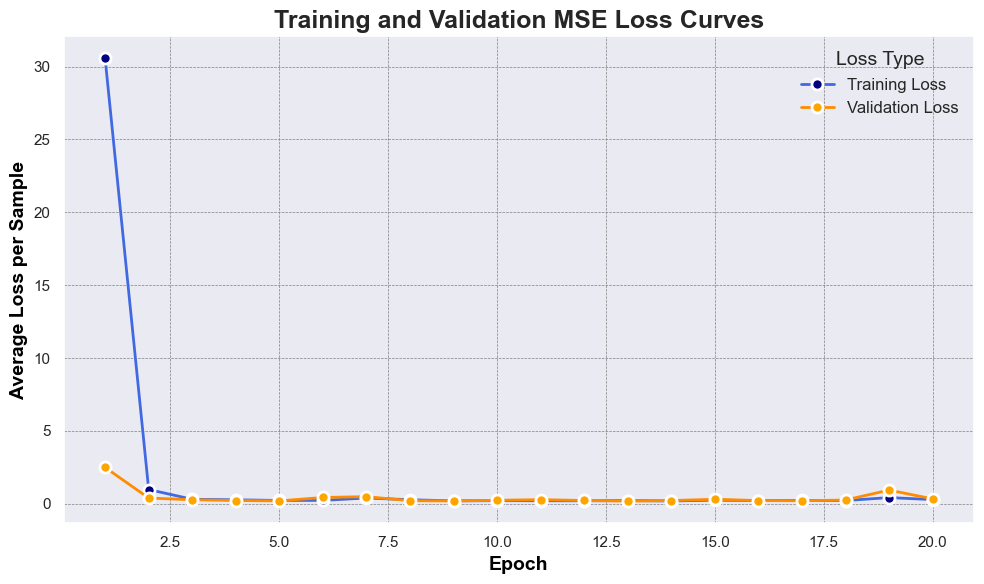

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming train_losses and val_losses are given as lists or arrays
train_losses = np.array(train_losses)  # Replace with your actual data
val_losses = np.array(val_losses)  # Replace with your actual data

# Generate a DataFrame for better plotting with seaborn
epochs = np.arange(1, len(train_losses) + 1)  # Create an array of epoch numbers

data = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': train_losses,
    'Validation Loss': val_losses
})

# Set the seaborn style to 'darkgrid' for a more aesthetic background
sns.set(style="darkgrid", palette="muted")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Training Loss with a nice color
sns.lineplot(data=data, x='Epoch', y='Training Loss', label='Training Loss', 
             color='royalblue', lw=2, marker='o', markersize=8, markerfacecolor='navy', markeredgewidth=2)

# Plot Validation Loss with a contrasting color
sns.lineplot(data=data, x='Epoch', y='Validation Loss', label='Validation Loss', 
             color='darkorange', lw=2, marker='o', markersize=8, markerfacecolor='orange', markeredgewidth=2)

# Add title and labels with an aesthetic font
plt.title('Training and Validation MSE Loss Curves', fontsize=18, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold', color='black')
plt.ylabel('Average Loss per Sample', fontsize=14, weight='bold', color='black')

# Add gridlines with a lighter color for better visibility
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Add legend with a custom position and style
plt.legend(title='Loss Type', loc='upper right', fontsize=12, title_fontsize=14, frameon=False)

# Make sure the layout fits nicely
plt.tight_layout()

# Show the plot
plt.show()
